In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import shapely.geometry as geo
import geopandas as gpd
from sklearn.neighbors import KDTree
from tqdm import tqdm

In [2]:
consider_cantons = False

In [3]:
# load in vehicle stock (BEDDEM)
year = 2018
df_vehicles = pd.read_csv("/home/ctchervenkov/git/JA_Mobility_exchange/BEDDEM-MATSIM/01-disaggregatedvehiclestock." + str(year) + ".csv")
df_vehicles = df_vehicles.rename({"ID" : "agent_id", 
                                  "Type_Of_Vehicle" : "vehicle_type", 
                                  "Powertrain" : "powertrain", 
                                  "Cons" : "consumption"}, axis=1)

df_vehicles = df_vehicles[["vehicle_type", "powertrain", "consumption", "CO2"]]
df_vehicles = df_vehicles.groupby(["vehicle_type", "powertrain"]).mean().reset_index()
df_vehicles.head()

,vehicle_type,powertrain,consumption,CO2
0,Bike (low price),NM,0.00,0.000000
1,City-car,D,0.04,107.083333
2,City-car,E,0.12,0.000000
3,City-car,G,0.04,107.083333
4,City-car,GSL,0.04,107.083333


In [4]:
# load in trips (BEDDEM)
year = 2018
df_trips = pd.read_csv("/home/ctchervenkov/git/JA_Mobility_exchange/BEDDEM-MATSIM/03-trips." + str(year) + ".csv")
df_trips.sort_values("AgentID").head()
print(df_trips["Vehicle_Category"].unique())
print()
print("number of total agents:", len(df_trips["AgentID"].unique()))

['Bike (low price)' 'Walking' 'City-car' 'Train' 'Family car'
 'SUV - compact' 'Luxury car' 'Executive car' 'SUV-normal' 'Bus'
 'Sporty supercar' 'Tram' 'Mini-car / quadricycles']

number of total agents: 3075


In [5]:
# select only car trips
df_trips = df_trips[df_trips["Mode"] == "Car"].reset_index(drop=True)
df_trips = df_trips.rename({"AgentID" : "agent_id",
                            "gemeindetype" : "municipality_type",
                            "Kanton" : "canton",
                            "Vehicle_Category" : "vehicle_type",
                            "Vehicle_Type" : "powertrain", 
                            "Day_Of_The_Week" : "day_of_week", 
                            "Time_Start" : "time_start",
                            "Weather" : "weather",
                            "Mode" : "mode", 
                            "Distance" : "distance",
                            "Purpose" : "purpose",
                            "Weight_To_Universe" : "weight"}, axis=1)

print("number of car-driving agents:", len(df_trips["agent_id"].unique()))
print()
print(df_trips["vehicle_type"].unique())
df_trips.sort_values("agent_id").head()

number of car-driving agents: 2179

['City-car' 'Family car' 'SUV - compact' 'Luxury car' 'Executive car'
 'SUV-normal' 'Sporty supercar' 'Mini-car / quadricycles']


,agent_id,municipality_type,canton,day_of_week,time_start,distance,purpose,mode,vehicle_type,powertrain,weather,weight
0,100072,1,21,6,17.30,3.46,8,Car,City-car,G,good,1272
27,100072,1,21,2,15.10,5.44,7,Car,City-car,G,good,1272
28,100072,1,21,5,6.45,21.90,2,Car,City-car,G,good,1272
29,100072,1,21,1,10.35,7.92,7,Car,City-car,G,good,1272
30,100072,1,21,0,6.45,21.90,2,Car,City-car,G,good,1272


In [6]:
# merge vehicle info
df_trips_beddem = pd.merge(df_trips, 
                           df_vehicles, 
                           on=["vehicle_type", "powertrain"])

print(len(df_trips["agent_id"].unique()))
print(len(df_trips_beddem["agent_id"].unique()))


df_trips_beddem = df_trips_beddem[["agent_id",
                                   "municipality_type",
                                   "canton", 
                                   "day_of_week", 
                                   "mode",
                                   "distance", 
                                   "vehicle_type", 
                                   "powertrain", 
                                   "consumption",
                                   "weight"]]

df_trips_beddem = df_trips_beddem.sort_values(["agent_id", "day_of_week"]) 

df_trips_beddem.head()

2179
2179


,agent_id,municipality_type,canton,day_of_week,mode,distance,vehicle_type,powertrain,consumption,weight
2,100072,1,21,0,Car,21.38,City-car,G,0.04,1272
13,100072,1,21,0,Car,7.92,City-car,G,0.04,1272
14,100072,1,21,0,Car,12.30,City-car,G,0.04,1272
17,100072,1,21,0,Car,3.46,City-car,G,0.04,1272
19,100072,1,21,0,Car,5.44,City-car,G,0.04,1272


In [7]:
# aggregate distance travelled by car (BEDDEM)
df_trips_beddem = df_trips_beddem[df_trips_beddem["day_of_week"] < 5] 
df_agents_beddem = (df_trips_beddem
                    .groupby(["agent_id", "municipality_type", 
                              "canton", "day_of_week", 
                              "vehicle_type", "powertrain", 
                              "consumption", "weight"])["distance"]
                    .agg(["sum", "count"])
                    .rename(columns={"sum": "distance", "count": "number_trips"})
                    .reset_index()
                    .groupby(["agent_id", "municipality_type",
                              "canton", "vehicle_type", 
                              "powertrain", "consumption"])
                    .mean()
                    .reset_index()
                   )

print(len(df_agents_beddem["agent_id"].unique()))
df_agents_beddem.head()

2179


,agent_id,municipality_type,canton,vehicle_type,powertrain,consumption,day_of_week,weight,distance,number_trips
0,100072,1,21,City-car,G,0.04,2.0,1272.0,92.70,7.0
1,100325,2,3,City-car,G,0.04,2.0,1418.0,16.06,2.0
2,100377,1,24,City-car,PGSL,0.02,2.0,1225.0,1.21,1.0
3,100423,6,2,City-car,G,0.04,2.0,3957.0,67.58,6.0
4,100640,1,12,Family car,G,0.05,2.0,3166.0,4.39,2.0


In [8]:
# load in trips (MATSim)
df_trips_matsim = pd.read_csv("/home/ctchervenkov/Documents/data/scenarios/switzerland_2018_10pct/output_trips.csv", sep=";")
df_trips_matsim.head()

,person_id,person_trip_id,origin_x,origin_y,destination_x,destination_y,start_time,travel_time,network_distance,mode,preceedingPurpose,followingPurpose,returning,crowfly_distance
0,7607985,0,2.595848e+06,1.123250e+06,2.595975e+06,1.123398e+06,0.0,70.0,0.414224,car,home,work,False,0.194511
1,3956472,0,2.611620e+06,1.268165e+06,2.612095e+06,1.268386e+06,0.0,144.0,0.823471,car,home,work,False,0.524534
2,1346393,0,2.681438e+06,1.246555e+06,2.681478e+06,1.247443e+06,0.0,178.0,1.173595,car,home,work,False,0.888177
3,3318350,0,2.682222e+06,1.224801e+06,2.681532e+06,1.225181e+06,0.0,202.0,1.613966,car,home,work,False,0.787492
4,3082912,0,2.692071e+06,1.208145e+06,2.690956e+06,1.208971e+06,0.0,221.0,1.938969,car,home,work,False,1.387174


In [9]:
# filter only car trips
df_trips_car = df_trips_matsim[df_trips_matsim["mode"] == "car"]

In [10]:
# remove trips under 1 m
df_trips_car = df_trips_car[df_trips_car["network_distance"] > 0.001]

In [11]:
# aggregate distance travelled by car (MATSim)
df_trips_matsim_agg = (df_trips_car[["person_id","network_distance"]]
                       .sort_values("person_id")
                       .groupby("person_id")["network_distance"]
                       .agg(["sum", "count"])
                       .rename(columns={"sum": "network_distance", "count": "number_trips"})
                       .reset_index()
                      )

df_trips_matsim_agg.head()

,person_id,network_distance,number_trips
0,31,26.598494,6
1,127,81.644679,2
2,130,99.493465,2
3,150,29.049295,4
4,151,50.524947,2


In [12]:
# load municipality shapefile
shp = "/home/ctchervenkov/Documents/data/switzerland/data/municipality_borders/gd-b-00.03-875-gg18/ggg_2018-LV95/shp/g1g18.shp"
df_municipalities = gpd.read_file(shp, encoding = "latin1").to_crs({'init': 'EPSG:2056'})
df_municipalities = df_municipalities[["GMDNR", "geometry"]].rename({"GMDNR":"municipality_id"}, axis=1)
df_municipalities.head()

,municipality_id,geometry
0,1,"POLYGON ((2678219 1235219.000000003, 2678439 1..."
1,2,"POLYGON ((2678219 1235219.000000003, 2677940 1..."
2,3,"POLYGON ((2675803 1241038.999999995, 2675748 1..."
3,4,"POLYGON ((2686024 1230187.000000002, 2684995 1..."
4,5,"POLYGON ((2675803 1241038.999999995, 2676538 1..."


In [13]:
# load canton and municipality type data
df_municipality_types = pd.read_excel("/home/ctchervenkov/Documents/data/switzerland/data/spatial_structure_2018.xlsx",
                               names=["municipality_id", "canton_id", "municipality_type"],
                               usecols=[0, 2, 21],
                               skiprows=6,
                               nrows=2229,
                               )
df_municipality_types.head()

,municipality_id,canton_id,municipality_type
0,1,1,4
1,2,1,2
2,3,1,4
3,4,1,7
4,5,1,4


In [14]:
def to_gpd(df, x = "x", y = "y", crs = {"init" : "EPSG:2056"}):
    df["geometry"] = [
        geo.Point(*coord) for coord in tqdm(
            zip(df[x], df[y]), total = len(df),
            desc = "Converting coordinates"
        )]
    df = gpd.GeoDataFrame(df)
    df.crs = crs

    if not crs == {"init" : "EPSG:2056"}:
        df = df.to_crs({"init" : "EPSG:2056"})

    return df

In [15]:
def impute(df_points, df_zones, point_id_field, zone_id_field, fix_by_distance = True, chunk_size = 10000):
    assert(type(df_points) == gpd.GeoDataFrame)
    assert(type(df_zones) == gpd.GeoDataFrame)

    assert(point_id_field in df_points.columns)
    assert(zone_id_field in df_zones.columns)
    assert(not zone_id_field in df_points.columns)

    df_original = df_points
    df_points = df_points[[point_id_field, "geometry"]]
    df_zones = df_zones[[zone_id_field, "geometry"]]

    print("Imputing %d zones into %d points by spatial join..." % (len(df_zones), len(df_points)))

    result = []
    chunk_count = max(1, int(len(df_points) / chunk_size))
    for chunk in tqdm(np.array_split(df_points, chunk_count), total = chunk_count):
        result.append(gpd.sjoin(df_zones, chunk, op = "contains", how = "right"))
    df_points = pd.concat(result).reset_index()

    if "left_index" in df_points: del df_points["left_index"]
    if "right_index" in df_points: del df_points["right_index"]

    invalid_mask = pd.isnull(df_points[zone_id_field])

    if fix_by_distance and np.any(invalid_mask):
        print("  Fixing %d points by centroid distance join..." % np.count_nonzero(invalid_mask))
        coordinates = np.vstack([df_zones["geometry"].centroid.x, df_zones["geometry"].centroid.y]).T
        kd_tree = KDTree(coordinates)

        df_missing = df_points[invalid_mask]
        coordinates = np.vstack([df_missing["geometry"].centroid.x, df_missing["geometry"].centroid.y]).T
        indices = kd_tree.query(coordinates, return_distance = False).flatten()

        df_points.loc[invalid_mask, zone_id_field] = df_zones.iloc[indices][zone_id_field].values

    return pd.merge(df_original, df_points[[point_id_field, zone_id_field]], on = point_id_field, how = "left")

In [16]:
# impute canton and municipality of agent's home location
df_home_matsim = df_trips_matsim[["person_id", "preceedingPurpose", "origin_x", "origin_y"]]
df_home_matsim = df_home_matsim[df_home_matsim["preceedingPurpose"] == "home"]
df_home_matsim = df_home_matsim.drop_duplicates().rename({"origin_x" : "x", "origin_y" : "y"}, axis=1)[["person_id", "x", "y"]]
df_home_matsim = to_gpd(df_home_matsim, "x", "y")
df_home_matsim = df_home_matsim.drop(["x", "y"], axis=1)
df_home_matsim.head()

Converting coordinates: 100%|██████████| 789538/789538 [00:07<00:00, 110943.72it/s]


,person_id,geometry
0,7607985,POINT (2595847.762529659 1123250.284521453)
1,3956472,POINT (2611619.512861282 1268164.885948657)
2,1346393,POINT (2681437.802471209 1246555.363873946)
3,3318350,POINT (2682221.75762797 1224801.036422773)
4,3082912,POINT (2692070.853172512 1208144.881176477)


In [17]:
df_home = impute(df_home_matsim, df_municipalities, "person_id", "municipality_id")
df_home = pd.merge(df_home, df_municipality_types, on="municipality_id")
df_home = df_home[["person_id", "canton_id", "municipality_type"]]
df_home.head()

  0%|          | 0/78 [00:00<?, ?it/s]

Imputing 2225 zones into 789538 points by spatial join...


100%|██████████| 78/78 [00:52<00:00,  1.76it/s]


  Fixing 254 points by centroid distance join...


,person_id,canton_id,municipality_type
0,7607985,23,4
1,7610315,23,4
2,7607987,23,4
3,7609772,23,4
4,7609846,23,4


In [18]:
print(len(df_home_matsim["person_id"]))
print(len(df_home_matsim["person_id"].unique()))
print(len(df_home["person_id"]))
print(len(df_home["person_id"].unique()))

789538
789538
789538
789538


In [19]:
# merge spatial info
df_trips_matsim_agg = pd.merge(df_trips_matsim_agg, df_home, on="person_id")
df_trips_matsim_agg = df_trips_matsim_agg.sort_values(["canton_id", "municipality_type"])
df_trips_matsim_agg.head()

,person_id,network_distance,number_trips,canton_id,municipality_type
13024,291644,18.500769,4,1,1
13025,291645,35.304981,4,1,1
15459,345815,1.508046,2,1,1
15460,345816,31.891081,4,1,1
15743,352088,19.126603,5,1,1


In [20]:
# match MATSim agents to BedDem agents
canton_ids = df_trips_matsim_agg["canton_id"].unique()

with tqdm(desc="Matching MATSim agents to BedDem agents", total=len(canton_ids)) as canton_progress:
    for canton_id in canton_ids:
        
        # create MATSim canton filter
        f_matsim_caton = (df_trips_matsim_agg["canton_id"] == canton_id)

        # create BEDDEM filters
        f_beddem = np.ones(len(df_agents_beddem), dtype=np.bool)
        f_beddem_canton = (df_agents_beddem["canton"] == canton_id)

        municipality_types = df_trips_matsim_agg.loc[f_matsim_caton, "municipality_type"].unique()
        for municipality_type in municipality_types:
            
            # get relevant MATSim agents
            f_matsim_municipality = (df_trips_matsim_agg["municipality_type"] == municipality_type)
            f_matsim = (f_matsim_caton & f_matsim_municipality)

            # get relevant BEDDEM agents
            f_beddem_municipality = (df_agents_beddem["municipality_type"] == municipality_type)
            
            # consider cantons when matching
            if consider_cantons:
                f_beddem = (f_beddem_canton & f_beddem_municipality)

                # if no match, only consider municipality type
                if (np.sum(f_beddem) == 0):
                    f_beddem = f_beddem_municipality
                    
            # only consider municipality type
            else:
                f_beddem = f_beddem_municipality

            # create KDtree from BEDDEM agents
            coordinates = np.vstack([df_agents_beddem.loc[f_beddem, "distance"].values]).T
            kd_tree = KDTree(coordinates)

            # match MATSim agents
            matsim_pts = np.vstack([df_trips_matsim_agg.loc[f_matsim, "network_distance"].values]).T
            indices = kd_tree.query(matsim_pts, return_distance=False).flatten()
            df_matches = df_agents_beddem.loc[f_beddem, :].iloc[list(indices)]

            df_trips_matsim_agg.loc[f_matsim, "agent_id"] = df_matches.loc[:, "agent_id"].values
            df_trips_matsim_agg.loc[f_matsim, "canton_id_beddem"] = df_matches.loc[:, "canton"].values
            df_trips_matsim_agg.loc[f_matsim, "municipality_type_beddem"] = df_matches.loc[:, "municipality_type"].values
            df_trips_matsim_agg.loc[f_matsim, "vehicle_type"] = df_matches.loc[:, "vehicle_type"].values
            df_trips_matsim_agg.loc[f_matsim, "powertrain"] = df_matches.loc[:, "powertrain"].values
            df_trips_matsim_agg.loc[f_matsim, "consumption"] = df_matches.loc[:, "consumption"].values
            df_trips_matsim_agg.loc[f_matsim, "distance_beddem"] = df_matches.loc[:, "distance"].values
            df_trips_matsim_agg.loc[f_matsim, "number_trips_beddem"] = df_matches.loc[:, "number_trips"].values

        canton_progress.update()

Matching MATSim agents to BedDem agents: 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]


In [21]:
df_trips_matsim_agg.head()

,person_id,network_distance,number_trips,canton_id,municipality_type,agent_id,canton_id_beddem,municipality_type_beddem,vehicle_type,powertrain,consumption,distance_beddem,number_trips_beddem
13024,291644,18.500769,4,1,1,397611.0,2.0,1.0,Family car,H,0.21,18.46,1.0
13025,291645,35.304981,4,1,1,153003.0,22.0,1.0,Family car,G,0.05,35.37,4.0
15459,345815,1.508046,2,1,1,468227.0,22.0,1.0,Family car,E,0.21,1.46,2.0
15460,345816,31.891081,4,1,1,229799.0,2.0,1.0,SUV-normal,G,0.06,31.99,7.0
15743,352088,19.126603,5,1,1,137407.0,1.0,1.0,SUV-normal,H,0.24,19.20,8.0


Text(0, 0.5, 'BEDDEM daily distance by car (km)')

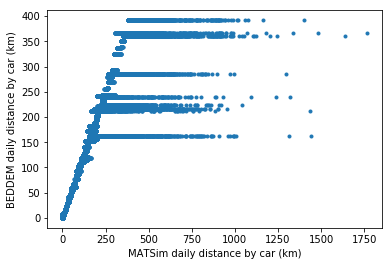

In [22]:
# distance matching -- line plot
plt.plot(df_trips_matsim_agg["network_distance"].values, df_trips_matsim_agg["distance_beddem"].values, ".")
plt.xlabel("MATSim daily distance by car (km)")
plt.ylabel("BEDDEM daily distance by car (km)")

Error <= 25%: 0.9853503703100839
Error > 25%: 0.01266582566940669


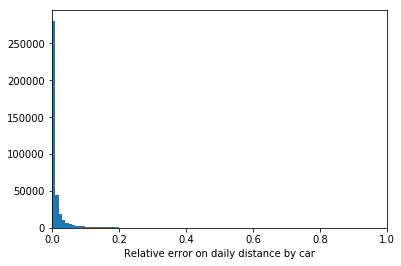

In [23]:
# distance matching -- relative error
dist_rel_err = np.abs(df_trips_matsim_agg["network_distance"].values - df_trips_matsim_agg["distance_beddem"].values) / df_trips_matsim_agg["network_distance"].values
dist_rel_err = dist_rel_err[dist_rel_err < 1 ]
plt.hist(dist_rel_err, 100)
plt.xlim((0,1))
plt.xlabel("Relative error on daily distance by car")
plt.savefig('/home/ctchervenkov/Documents/projects/sccer_ja/python/plots/distance_comparison.pdf')


print("Error <= 25%:", np.sum(dist_rel_err <= 0.25) / len(df_trips_matsim_agg))
print("Error > 25%:", np.sum(dist_rel_err > 0.25) / len(df_trips_matsim_agg))

Absolute error <= 2 trips: 0.7672336615935542
Absolute error > 2 trips: 0.23276633840644584


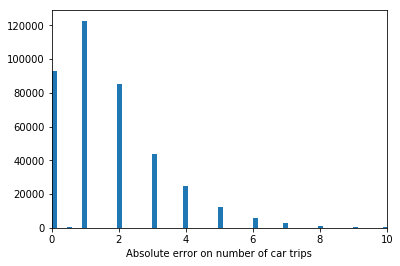

In [24]:
# number of trips matching -- absolute error
trips_abs_err = np.abs(df_trips_matsim_agg["number_trips"].values - df_trips_matsim_agg["number_trips_beddem"].values)
plt.hist(trips_abs_err, 100)
plt.xlim((0,10))
plt.xlabel("Absolute error on number of car trips")
plt.savefig('/home/ctchervenkov/Documents/projects/sccer_ja/python/plots/number_trips_comparison.pdf')

print("Absolute error <= 2 trips:", np.sum(trips_abs_err <= 2) / len(df_trips_matsim_agg))
print("Absolute error > 2 trips:", np.sum(trips_abs_err > 2) / len(df_trips_matsim_agg))

In [25]:
# compare canton matching
print("Correctly matched cantons:",np.sum(df_trips_matsim_agg["canton_id"].values == df_trips_matsim_agg["canton_id_beddem"].values) / len(df_trips_matsim_agg))
print("Incorrectly matched cantons:",np.sum(df_trips_matsim_agg["canton_id"].values != df_trips_matsim_agg["canton_id_beddem"].values) / len(df_trips_matsim_agg))

Correctly matched cantons: 0.10761628143566371
Incorrectly matched cantons: 0.8923837185643363


In [26]:
# compare municipality type matching
print("Correctly matched municipality types:", np.sum(df_trips_matsim_agg["municipality_type"].values == df_trips_matsim_agg["municipality_type_beddem"].values) / len(df_trips_matsim_agg))
print("Incorrectly matched municipality types:",np.sum(df_trips_matsim_agg["municipality_type"].values != df_trips_matsim_agg["municipality_type_beddem"].values) / len(df_trips_matsim_agg))

Correctly matched municipality types: 1.0
Incorrectly matched municipality types: 0.0


In [27]:
# matsim vehicle stock
df_vehicle_stock_matsim = (df_trips_matsim_agg[["vehicle_type", "powertrain"]]
                           .groupby(["vehicle_type", "powertrain"])
                           .size()
                           .reset_index()
                           .rename(columns={0: "count"})
                          )

df_vehicle_stock_matsim.head()

,vehicle_type,powertrain,count
0,City-car,D,4998
1,City-car,E,1187
2,City-car,G,145214
3,City-car,GSL,18829
4,City-car,H,495


In [28]:
# beddem stock for agents using car
df_vehicle_stock_beddem = (df_agents_beddem[["vehicle_type", "powertrain", "weight"]]
                           .groupby(["vehicle_type", "powertrain"])
                           .sum()
                           .reset_index()
                           .rename(columns={"weight": "count"})
                          )

df_vehicle_stock_beddem.head()

,vehicle_type,powertrain,count
0,City-car,D,93541.0
1,City-car,E,15295.0
2,City-car,G,2007846.0
3,City-car,GSL,284877.0
4,City-car,H,5908.0


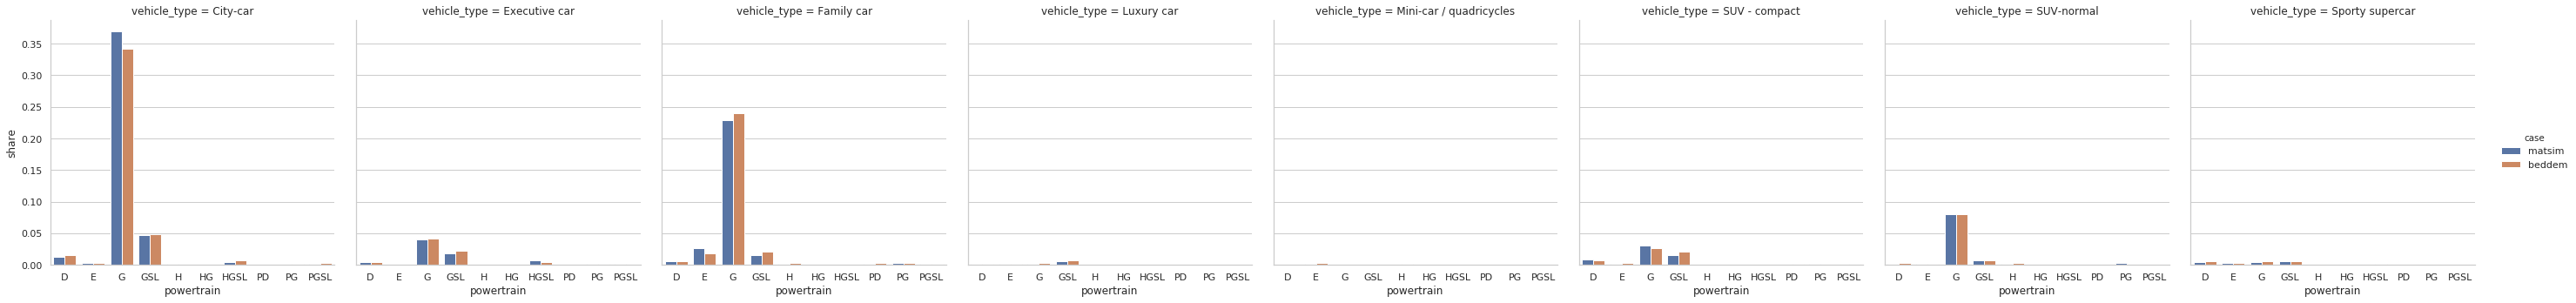

In [29]:
# compare stocks
df_vehicle_stock_compare = pd.merge(df_vehicle_stock_matsim, df_vehicle_stock_beddem, 
                                    on=["vehicle_type", "powertrain"], 
                                    how="outer", 
                                    suffixes=["_matsim", "_beddem"]).fillna(0.0)

df_vehicle_stock_compare["count_matsim"] = df_vehicle_stock_compare["count_matsim"] / np.sum(df_vehicle_stock_compare["count_matsim"])
df_vehicle_stock_compare["count_beddem"] = df_vehicle_stock_compare["count_beddem"] / np.sum(df_vehicle_stock_compare["count_beddem"])

a = df_vehicle_stock_compare.rename({"count_matsim":"share"}, axis=1).drop("count_beddem", axis=1)
b = df_vehicle_stock_compare.rename({"count_beddem":"share"}, axis=1).drop("count_matsim", axis=1)

a["case"] = "matsim"
b["case"] = "beddem"

df_vehicle_stock_compare = pd.concat([a, b])

import seaborn as sns
sns.set(style="whitegrid")
ax1 = sns.catplot(x="powertrain", y="share",
                  hue="case",
                  col="vehicle_type",
                  kind="bar",
                  data=df_vehicle_stock_compare)

ax1.savefig('/home/ctchervenkov/Documents/projects/sccer_ja/python/plots/vehicle_stock_comparison.pdf')

In [30]:
# merge vehicle info into matsim car trips
df_matsim_agent_veh = df_trips_matsim_agg[["person_id", "vehicle_type", "powertrain", "consumption"]]
df_trips_w_veh = pd.merge(df_trips_car, df_matsim_agent_veh, on="person_id")

# get end times
df_trips_w_veh.loc[:,"endTime"] = df_trips_w_veh.loc[:,"start_time"] + df_trips_w_veh.loc[:,"travel_time"]

# rename columns
renames = {"person_id":"vehicleId",
           "vehicle_type":"vehicleType",
           "start_time":"startTime",
           "origin_x":"startX",
           "origin_y":"startY",
           "destination_x":"endX",
           "destination_y":"endY",
           "preceedingPurpose":"startActivityType",
           "followingPurpose":"endActivityType",
           "network_distance":"travelDistance_km"}

df_trips_w_veh = df_trips_w_veh.rename(index=str, columns=renames)

# only keep desired columns
df_trips_w_veh = df_trips_w_veh[["vehicleId",
                                 "vehicleType", 
                                 "powertrain", 
                                 "consumption",
                                 "startTime",
                                 "endTime",
                                 "startX",
                                 "startY",
                                 "endX",
                                 "endY",
                                 "startActivityType",
                                 "endActivityType",
                                 "travelDistance_km"]]

# set to desired format
df_trips_w_veh.loc[:,"vehicleId"] = df_trips_w_veh.loc[:,"vehicleId"].astype(int)
df_trips_w_veh.loc[:,"vehicleType"] = df_trips_w_veh.loc[:,"vehicleType"].astype(str)
df_trips_w_veh.loc[:,"powertrain"] = df_trips_w_veh.loc[:,"powertrain"].astype(str)
df_trips_w_veh.loc[:,"consumption"] = df_trips_w_veh.loc[:,"consumption"].astype(float)
df_trips_w_veh.loc[:,"startTime"] = df_trips_w_veh.loc[:,"startTime"].astype(float)
df_trips_w_veh.loc[:,"endTime"] = df_trips_w_veh.loc[:,"endTime"].astype(float)
df_trips_w_veh.loc[:,"startX"] = df_trips_w_veh.loc[:,"startX"].astype(float)
df_trips_w_veh.loc[:,"startY"] = df_trips_w_veh.loc[:,"startY"].astype(float)
df_trips_w_veh.loc[:,"endX"] = df_trips_w_veh.loc[:,"endX"].astype(float)
df_trips_w_veh.loc[:,"endY"] = df_trips_w_veh.loc[:,"endY"].astype(float)
df_trips_w_veh.loc[:,"startActivityType"] = df_trips_w_veh.loc[:,"startActivityType"].astype(str)
df_trips_w_veh.loc[:,"endActivityType"] = df_trips_w_veh.loc[:,"endActivityType"].astype(str)
df_trips_w_veh.loc[:,"travelDistance_km"] = df_trips_w_veh.loc[:,"travelDistance_km"].astype(float)

# sort by timestamp
df_trips_w_veh = df_trips_w_veh.sort_values(by=["startTime","endTime"])
df_trips_w_veh.head()

,vehicleId,vehicleType,powertrain,consumption,startTime,endTime,startX,startY,endX,endY,startActivityType,endActivityType,travelDistance_km
0,7607985,City-car,G,0.04,0.0,70.0,2.595848e+06,1.123250e+06,2.595975e+06,1.123398e+06,home,work,0.414224
2,3956472,Family car,G,0.05,0.0,144.0,2.611620e+06,1.268165e+06,2.612095e+06,1.268386e+06,home,work,0.823471
4,1346393,City-car,G,0.04,0.0,178.0,2.681438e+06,1.246555e+06,2.681478e+06,1.247443e+06,home,work,1.173595
6,3318350,SUV - compact,GSL,0.05,0.0,202.0,2.682222e+06,1.224801e+06,2.681532e+06,1.225181e+06,home,work,1.613966
8,3082912,SUV-normal,G,0.06,0.0,221.0,2.692071e+06,1.208145e+06,2.690956e+06,1.208971e+06,home,work,1.938969


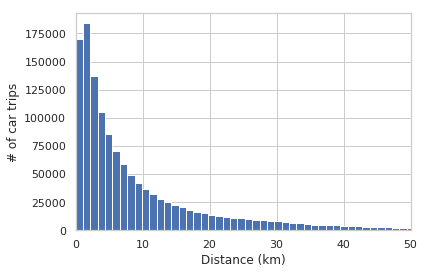

In [31]:
# plot distance distribution
data = df_trips_w_veh["travelDistance_km"].values
plt.hist(data, bins=500)
plt.xlim((0,50))
plt.xlabel("Distance (km)")
plt.ylabel("# of car trips")
plt.show()

In [32]:
# save to file
df_trips_w_veh.to_csv("/home/ctchervenkov/Documents/projects/sccer_ja/switzerland_10pct/01-Time_of_trips-origin_destination_vehicle_trip_distance.csv", sep=",", index=False)